In [107]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics



In [76]:
cwd = os.path.abspath(os.pardir)
data_file = os.path.join(cwd, 'dat', 'EURUSD1.csv')

col = ['date','time','open','high','low','close','volume']

df = pd.read_csv(data_file, header=None)
df.columns = col

df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])

df.index = df['datetime']
'''
df['year'] = pd.DatetimeIndex(df['datetime']).year
df['month'] = pd.DatetimeIndex(df['datetime']).month
df['day'] = pd.DatetimeIndex(df['datetime']).day

'''

df['hour'] = pd.DatetimeIndex(df['datetime']).hour
df['minute'] = pd.DatetimeIndex(df['datetime']).minute

df['average_price'] = df[['open','high','low','close']].mean(axis=1)


df['return_avg_price'] = df['average_price'].pct_change()
df['log_return_avg_price'] = np.log(1 + df['return_avg_price'])

df['return_close_price'] = df['close'].pct_change()
df['log_return_close_price'] = np.log(1 + df['return_close_price'])

df['stdev'] = df['average_price'].rolling(10).std()
df['momentum'] = 1 + df['average_price'].pct_change(periods=10)
df['momentum2'] = df['momentum'].cumprod()

df['momentum3'] = df['momentum2'].pct_change()


df['trend'] = 0
df.loc[ df['momentum3'] >  0.0001, 'trend' ] =  1
df.loc[ df['momentum3'] < -0.0001, 'trend' ] = -1


df.head()


,date,time,open,high,low,close,volume,datetime,hour,minute,average_price,return_avg_price,log_return_avg_price,return_close_price,log_return_close_price,stdev,momentum,momentum2,momentum3,trend
datetime,,,,,,,,,,,,,,,,,,,,
2018-08-07 07:09:00,2018.08.07,07:09,1.15578,1.15579,1.15578,1.15579,6,2018-08-07 07:09:00,7,9,1.155785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2018-08-07 07:10:00,2018.08.07,07:10,1.15579,1.15583,1.15575,1.15578,32,2018-08-07 07:10:00,7,10,1.155787,0.000002,0.000002,-0.000009,-0.000009,NaN,NaN,NaN,NaN,0
2018-08-07 07:11:00,2018.08.07,07:11,1.15578,1.15580,1.15573,1.15578,29,2018-08-07 07:11:00,7,11,1.155773,-0.000013,-0.000013,0.000000,0.000000,NaN,NaN,NaN,NaN,0
2018-08-07 07:12:00,2018.08.07,07:12,1.15578,1.15582,1.15576,1.15582,13,2018-08-07 07:12:00,7,12,1.155795,0.000019,0.000019,0.000035,0.000035,NaN,NaN,NaN,NaN,0
2018-08-07 07:13:00,2018.08.07,07:13,1.15581,1.15584,1.15578,1.15584,9,2018-08-07 07:13:00,7,13,1.155817,0.000019,0.000019,0.000017,0.000017,NaN,NaN,NaN,NaN,0


In [88]:
df.columns
df.fillna(value=0, inplace=True)
cols_to_keep = ['hour', 'minute', 'return_avg_price', 'log_return_avg_price', 'return_close_price', 'log_return_close_price',
       'stdev', 'trend']

df.describe()

,open,high,low,close,volume,hour,minute,average_price,return_avg_price,log_return_avg_price,return_close_price,log_return_close_price,stdev,momentum,momentum2,momentum3,trend
count,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,6.500000e+04,6.500000e+04,6.500000e+04,6.500000e+04,65000.000000,65000.000000,65000.000000,6.500000e+04,65000.000000
mean,1.158906,1.158989,1.158825,1.158906,51.655569,11.607969,29.509000,1.158907,-7.727529e-08,-8.141192e-08,-7.393239e-08,-8.167920e-08,0.000133,0.999845,1.031399,-7.679325e-07,-0.006492
std,0.011045,0.011040,0.011049,0.011045,45.964681,6.907309,17.310403,0.011045,9.095401e-05,9.096019e-05,1.244727e-04,1.244751e-04,0.000115,0.012408,0.097098,3.668355e-04,0.816898
min,1.130210,1.130270,1.130060,1.130200,1.000000,0.000000,0.000000,1.130200,-3.465291e-03,-3.471309e-03,-3.480510e-03,-3.486581e-03,0.000000,0.000000,0.000000,-5.791728e-03,-1.000000
25%,1.152860,1.152940,1.152778,1.152868,20.000000,6.000000,15.000000,1.152862,-3.905898e-05,-3.905975e-05,-5.164811e-05,-5.164945e-05,0.000063,0.999832,0.974979,-1.677648e-04,-1.000000
50%,1.159910,1.159970,1.159840,1.159910,41.000000,12.000000,30.000000,1.159900,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000104,1.000000,1.036242,0.000000e+00,0.000000
75%,1.167240,1.167310,1.167170,1.167240,71.000000,18.000000,45.000000,1.167238,3.882557e-05,3.882482e-05,5.163289e-05,5.163156e-05,0.000168,1.000163,1.103686,1.627601e-04,1.000000
max,1.181290,1.181480,1.180990,1.181280,754.000000,23.000000,59.000000,1.181142,1.773639e-03,1.772068e-03,3.251241e-03,3.245967e-03,0.002074,1.004127,1.239431,4.127422e-03,1.000000


In [87]:
cols_to_keep = ['hour', 'minute', 'return_avg_price', 'log_return_avg_price', 'return_close_price', 'log_return_close_price',
       'stdev', 'trend']

X = df.loc[:, cols_to_keep].values
y = df.loc[:, 'close'].values



In [93]:
x_train = X
y_train = y



In [112]:

model = models.Sequential()
model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dense(64, activation='tanh'))
model.add(layers.Dense(32, activation='tanh'))
model.add(layers.Dense(16, activation='tanh'))
model.add(layers.Dense(8, activation='tanh'))
model.add(layers.Dense(4, activation='tanh'))
model.add(layers.Dense(2, activation='linear'))
model.add(layers.Dense(1))
model.compile(optimizer=optimizers.Adam(lr=0.1), 
              loss=losses.mse, 
              metrics=['mae'])




In [117]:
model.fit(x_train, y_train, epochs = 20, batch_size = 1024, verbose = 1)


Epoch 1/20
65000/65000 [==============================] - 0s 4us/step - loss: 1.2228e-04 - mean_absolute_error: 0.0086
Epoch 2/20
65000/65000 [==============================] - 0s 4us/step - loss: 1.2225e-04 - mean_absolute_error: 0.0086
Epoch 3/20
65000/65000 [==============================] - 0s 4us/step - loss: 1.2216e-04 - mean_absolute_error: 0.0086
Epoch 4/20
65000/65000 [==============================] - 0s 4us/step - loss: 1.2224e-04 - mean_absolute_error: 0.0086
Epoch 5/20
65000/65000 [==============================] - 0s 4us/step - loss: 1.2236e-04 - mean_absolute_error: 0.0086
Epoch 6/20
65000/65000 [==============================] - 0s 4us/step - loss: 1.2264e-04 - mean_absolute_error: 0.0087
Epoch 7/20
65000/65000 [==============================] - 0s 4us/step - loss: 1.2222e-04 - mean_absolute_error: 0.0086
Epoch 8/20
65000/65000 [==============================] - 0s 4us/step - loss: 1.2300e-04 - mean_absolute_error: 0.0087
Epoch 9/20
65000/65000 [========================

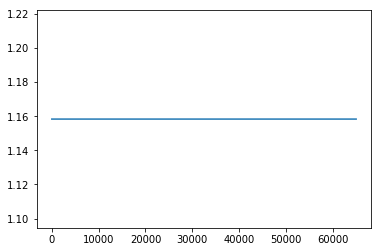

In [118]:
preds = model.predict(x_train)
#diff = preds - y
%matplotlib inline
plt.plot(preds)
plt.show()